## MOVIE RATING PREDICTION BASED ON MOVIE REVIEWS
### Deep Learning Final Project
#### Sahil Singh

In [108]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to /Users/sahil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sahil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data prepocessing and exploration

In [12]:
# my computer does not have a GPU but included for generalizing the use case of this notebook
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [25]:
folder_path = 'dataset/train/reviews'
files = os.listdir(folder_path)

review = []
rating = []


for file in files:
    if file.endswith('.txt'):  # Only read text files
        file_path = os.path.join(folder_path, file)
        with open(file_path, 'r') as f:
            text = f.read()
            review.append(text)
            # Extract digits after "_" in filename and append to file_ids list
            rate = int(file.split("_")[1].split(".")[0])
            rating.append(rate)


df = pd.DataFrame(list(zip(review, rating)), columns=['review', 'rating'])

def rating_to_sentiment(rating):
    if rating > 5:
        return "positive"
    else:
        return "negative"
    
def rating_to_label(rating):
    if rating > 5:
        return 1
    else:
        return 0

df['sentiment'] = df['rating'].apply(rating_to_sentiment)
df['label'] = df['rating'].apply(rating_to_label)

In [26]:
df.head()

,review,rating,sentiment,label
0,For a movie that gets no respect there sure ar...,9,positive,1
1,Bizarre horror movie filled with famous faces ...,8,positive,1
2,"A solid, if unremarkable film. Matthau, as Ein...",7,positive,1
3,Working with one of the best Shakespeare sourc...,4,negative,0
4,"Well...tremors I, the original started off in ...",1,negative,0


In [30]:
# checking for imbalances
df.sentiment.value_counts()

positive    12500
negative    12500
Name: sentiment, dtype: int64

In [31]:
#Finding the number of words in the reviews
df['token_length'] = df.review.progress_apply(lambda x: len(x.split()))

100%|██████████| 25000/25000 [00:00<00:00, 42569.20it/s]


In [36]:
# creating df with just positive reviews
df_p = df[df['label'] == 1]
df_p['token_length'].describe()

count    12500.000000
mean       236.706560
std        180.485743
min         12.000000
25%        125.000000
50%        174.000000
75%        291.000000
max       2470.000000
Name: token_length, dtype: float64

In [37]:
# creating df with just positive reviews
df_n = df[df['label'] == 0]
df_n['token_length'].describe()

count    12500.000000
mean       230.867840
std        166.663126
min         10.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

<Figure size 576x576 with 0 Axes>

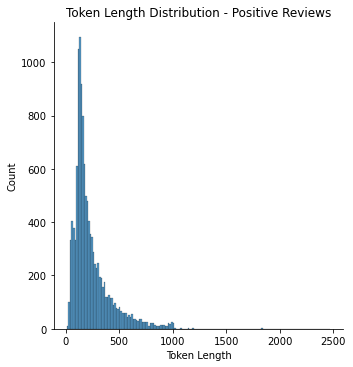

In [39]:
plt.figure(figsize=(8, 8))
sns.displot(df_p, x='token_length')
plt.title('Token Length Distribution - Positive Reviews')
plt.xlabel('Token Length')
plt.ylabel('Count')
plt.show()

<Figure size 576x576 with 0 Axes>

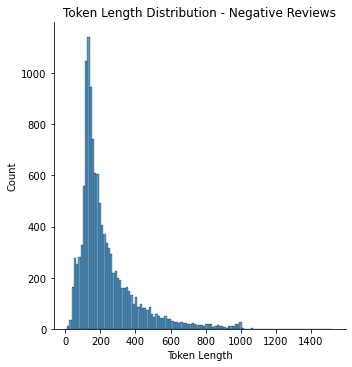

In [40]:
plt.figure(figsize=(8, 8))
sns.displot(df_n, x='token_length')
plt.title('Token Length Distribution - Negative Reviews')
plt.xlabel('Token Length')
plt.ylabel('Count')
plt.show()

In [59]:
# exploring some reviews
print('Positive')
print(df_p.loc[df_p['token_length'].idxmin(), 'review'])
print()
print('Negative')
print(df_n.loc[df_n['token_length'].idxmin(), 'review'])

Positive
Adrian Pasdar is excellent is this film. He makes a fascinating woman.

Negative
I wouldn't rent this one even on dollar rental night.


### Cleaning

In [60]:
# text cleaning
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

# handle case like "shut up okay?Im only 10 years old"
# become "shut up okay Im only 10 years old"
def rm_punct2(text):
    # return re.sub(r'[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)     # add whitespaces between punctuation
    s = re.sub(r'\s{2,}', ' ', s)        # remove double whitespaces    
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):    
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

In [61]:
# preprocessing
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [62]:
df['clean'] = df['review'].progress_apply(clean_pipeline)
df['processed'] = df['clean'].progress_apply(preprocess_pipeline)
df.head()

100%|██████████| 25000/25000 [01:59<00:00, 209.92it/s]


,review,rating,sentiment,label,token_length,clean,processed
0,For a movie that gets no respect there sure ar...,9,positive,1,52,For a movie that gets no respect there sure ar...,For movie get respect sure lot memorable quote...
1,Bizarre horror movie filled with famous faces ...,8,positive,1,166,Bizarre horror movie filled with famous faces ...,Bizarre horror movie filled famous face stolen...
2,"A solid, if unremarkable film. Matthau, as Ein...",7,positive,1,55,"A solid , if unremarkable film . Matthau , as ...","A solid , unremarkable film . Matthau , Einste..."
3,Working with one of the best Shakespeare sourc...,4,negative,0,41,Working with one of the best Shakespeare sourc...,"Working one best Shakespeare source , film man..."
4,"Well...tremors I, the original started off in ...",1,negative,0,188,"Well . . . tremors I , the original started of...","Well . . . tremor I , original started found m..."


Finally, after doing data preprocessing, we save our processed dataset into a new csv file for further usage.

In [74]:
# keep only processed, label and rating columns
df[['processed', 'label', 'rating']].to_csv('./imdb_processed.csv', index=False, header=True)

## Prepare Dataset

In [197]:
# read processed data
data = pd.read_csv('./imdb_processed.csv')

for row in data[:2].iterrows():
    print(row[1]['processed'])
    print(f'Label: {row[1]["label"]}')   
    print(f'Rating: {row[1]["rating"]}')   
    print('\n')

For movie get respect sure lot memorable quote listed gem . Imagine movie Joe Piscopo actually funny ! Maureen Stapleton scene stealer . The Moroni character absolute scream . Watch Alan The Skipper Hale jr . police Sgt .
Label: 1
Rating: 9


Bizarre horror movie filled famous face stolen Cristina Raines later TV Flamingo Road pretty somewhat unstable model gummy smile slated pay attempted suicide guarding Gateway Hell ! The scene Raines modeling well captured , mood music perfect , Deborah Raffin charming Cristina pal , Raines move creepy Brooklyn Heights brownstone inhabited blind priest top floor , thing really start cooking . The neighbor , including fantastically wicked Burgess Meredith kinky couple Sylvia Miles Beverly D Angelo , diabolical lot , Eli Wallach great fun wily police detective . The movie nearly cross - pollination Rosemary Baby The Exorcist - - combination ! Based best - seller Jeffrey Konvitz , The Sentinel entertainingly spooky , full shock brought well director M

In [76]:
# get all processed reviews
reviews = data.processed.values
# merge into single variable, separated by whitespaces
words = ' '.join(reviews)
# obtain list of words
words = words.split()

# check our list
words[:10]

['For',
 'movie',
 'get',
 'respect',
 'sure',
 'lot',
 'memorable',
 'quote',
 'listed',
 'gem']

In [77]:
# build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

In [78]:
# encode words
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

# print first-10 words of first 5 reviews
for i in range(5):
    print(reviews_enc[i][:5])

100%|██████████| 25000/25000 [00:02<00:00, 10240.08it/s]

[220, 5, 19, 933, 197]
[21716, 110, 5, 959, 681]
[47, 1049, 2, 9908, 6]
[14203, 8, 60, 1668, 1864]
[318, 1, 1, 1, 20440]


In [79]:
# padding sequences
def pad_features(reviews, pad_id, seq_length=128):
    # features = np.zeros((len(reviews), seq_length), dtype=int)
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10]

array([[  220,     5,    19,   933,   197,    77,   774,  2089,  3400,
         1207],
       [21716,   110,     5,   959,   681,   247,  2475,  9081,  4991,
          234],
       [   47,  1049,     2,  9908,     6,     1,  2876,     2,  5839,
            2],
       [14203,     8,    60,  1668,  1864,     2,     6,   872, 19319,
         1864],
       [  318,     1,     1,     1, 20440,     3,     2,   112,   522,
          170],
       [19320,     9,    14,     8,   114,  1239,   740,     1,    11,
          911],
       [   11,   608,   325,   740,   518,   517,  7741,   609, 20441,
          151],
       [    3,    46,  2025,     5,    37,     2,     8,   126,   708,
          177],
       [19323,  1019,  3561,    51,    86,    51,  4532,  2475, 17465,
          272],
       [  118,   161,   374,    41,     2,  5593,   178,    57,  3023,
         2288]])

In [82]:
# get ratings as numpy
ratings = data.rating.to_numpy()
ratings

array([9, 8, 7, ..., 1, 3, 3])

### Train, validation and test split

In [142]:
# train test split
train_size = .7   
val_size = .5   

split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = ratings[:split_id], ratings[split_id:]

split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (17500, 256)
Validation set: (3750, 256)
Test set: (3750, 256)


In [178]:
batch_size = 128

trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y-1))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y-1))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y-1))
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [198]:
# checking batches
dataiter = iter(trainloader)
x, y = next(dataiter)

print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample rating size: ', y.size())   # batch_size
print('Sample rating input: \n', y)

Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[   14,    13,   399,  ...,     0,     0,     0],
        [    3,    19,  7940,  ...,     0,     0,     0],
        [   14,   255,   177,  ...,     0,     0,     0],
        ...,
        [   14,     5,  3074,  ...,     0,     0,     0],
        [   42,     3,  2562,  ...,   208,   141,     2],
        [  838,  5168, 14592,  ...,     0,     0,     0]])

Sample rating size:  torch.Size([128])
Sample rating input: 
 tensor([1, 3, 0, 2, 0, 9, 3, 3, 2, 8, 9, 6, 9, 7, 7, 8, 6, 6, 3, 1, 0, 0, 2, 7,
        7, 0, 0, 3, 2, 3, 3, 3, 8, 9, 0, 3, 9, 9, 0, 0, 0, 0, 7, 1, 9, 6, 0, 1,
        1, 8, 3, 2, 3, 8, 3, 9, 0, 7, 6, 1, 7, 0, 7, 0, 9, 9, 0, 0, 9, 6, 9, 2,
        9, 6, 7, 0, 8, 3, 1, 6, 7, 1, 6, 3, 2, 9, 2, 8, 7, 9, 0, 3, 0, 0, 8, 0,
        0, 7, 1, 9, 9, 0, 7, 0, 7, 7, 0, 7, 9, 2, 1, 9, 7, 6, 7, 3, 2, 0, 1, 9,
        2, 2, 9, 1, 7, 0, 0, 3])


### Modelling

Using LSTM (Long Short-Term Memory) as the model

In [193]:
class MovieRatingModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(MovieRatingModel, self).__init__()

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Softmax layer for multiclass classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ =  self.lstm(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # apply softmax for multiclass classification
        o = self.softmax(o)

        return o

In [175]:
# model hyperparamters
vocab_size = len(word2int)
output_size = 10
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.25

model = MovieRatingModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

MovieRatingModel(
  (embedding): Embedding(86499, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


### Training

In [179]:
import torch.optim as optim
import matplotlib.pyplot as plt

model = MovieRatingModel(vocab_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
n_epochs = 10
train_losses, valid_losses = [], []
train_acc, valid_acc = [], []

for epoch in range(1, n_epochs+1):
    train_loss, correct_train = 0, 0
    model.train()
    
    for inputs, ratings in trainloader:
        inputs, ratings = inputs.to(device), ratings.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, ratings)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == ratings).sum().item()
        
    train_loss = train_loss / len(trainloader.dataset)
    train_losses.append(train_loss)
    train_acc.append(100. * correct_train / len(trainloader.dataset))
    valid_loss, correct_valid = 0, 0
    model.eval()

    with torch.no_grad():
        for inputs, ratings in valloader:
            inputs, ratings = inputs.to(device), ratings.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, ratings)
            valid_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_valid += (predicted == ratings).sum().item()
    
    valid_loss = valid_loss / len(valloader.dataset)
    valid_losses.append(valid_loss)
    valid_acc.append(100. * correct_valid / len(valloader.dataset))
    
    print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}, Train Acc: {:.2f}%, Valid Acc: {:.2f}%'
          .format(epoch, n_epochs, train_loss, valid_loss, train_acc[-1], valid_acc[-1]))

Epoch [1/10], Train Loss: 2.2331, Valid Loss: 2.2229, Train Acc: 20.00%, Valid Acc: 21.15%
Epoch [2/10], Train Loss: 2.2243, Valid Loss: 2.2191, Train Acc: 20.83%, Valid Acc: 24.37%
Epoch [3/10], Train Loss: 2.1959, Valid Loss: 2.1996, Train Acc: 25.54%, Valid Acc: 22.16%
Epoch [4/10], Train Loss: 2.1645, Valid Loss: 2.1657, Train Acc: 30.03%, Valid Acc: 29.31%
Epoch [5/10], Train Loss: 2.1319, Valid Loss: 2.1882, Train Acc: 33.06%, Valid Acc: 26.27%
Epoch [6/10], Train Loss: 2.0960, Valid Loss: 2.1464, Train Acc: 36.84%, Valid Acc: 31.25%
Epoch [7/10], Train Loss: 2.0639, Valid Loss: 2.1412, Train Acc: 39.82%, Valid Acc: 31.71%
Epoch [8/10], Train Loss: 2.0507, Valid Loss: 2.1464, Train Acc: 41.05%, Valid Acc: 30.99%
Epoch [9/10], Train Loss: 2.0386, Valid Loss: 2.1475, Train Acc: 42.30%, Valid Acc: 31.07%
Epoch [10/10], Train Loss: 2.0317, Valid Loss: 2.1443, Train Acc: 42.99%, Valid Acc: 31.31%


In [180]:
# save the trained model
torch.save(model.state_dict(), 'movie_rating_model.pt')

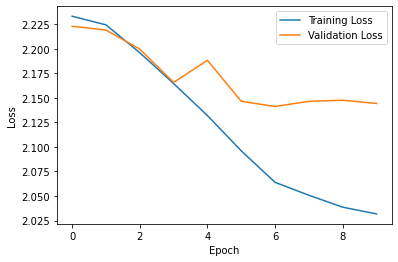

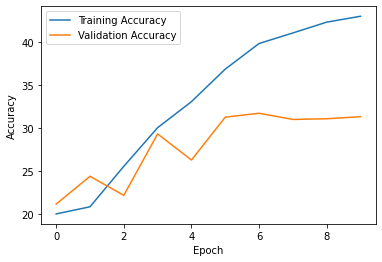

In [184]:
# plot the training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

So, as we can see from both graph above we can conclude that our model tends to not do too well. As you can see, the validation loss start to increasing after 6th epochs, and the validation accuracy also didn't improved significantly anymore after 6th epochs.

### Testing

In [188]:
model.eval()

test_loss, correct_test = 0, 0
test_acc = 0
test_losses = []

with torch.no_grad():
        for inputs, ratings in testloader:
            
            inputs, ratings = inputs.to(device), ratings.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, ratings)
            
            test_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_test += (predicted == ratings).sum().item()
            
test_loss = test_loss / len(testloader.dataset)
test_acc = 100. * correct_test / len(valloader.dataset)
print('Test Loss: ', test_loss)
print('Test Accuracy: ', test_acc, '%')

Test Loss:  2.3021603715260825
Test Accuracy:  18.88 %


Our model accuracy on test data not that good. It could predict unseen data `18.88%` correctly.

### Evaluation Metrics

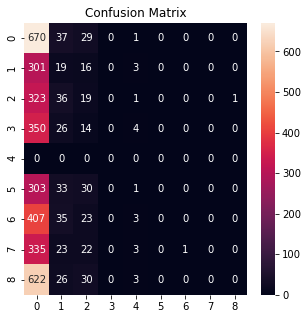

In [189]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_predicted = []
all_target = []

with torch.no_grad():

    for inputs, ratings in testloader:

        inputs, ratings = inputs.to(device), ratings.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predicted += predicted.cpu().numpy().tolist()
        all_target += ratings.cpu().numpy().tolist()

# create confusion matrix
cm = confusion_matrix(all_target, all_predicted)

# plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()